## Partie modélisation

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.feature_selection import r_regression
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

In [4]:
# # Définir les tranches de BMI
# # bins = [0, 18.5, 24.9, 29.9, 40, 100]  # Tranches de BMI
# # labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
# bins = [0, 29.999, 100]  # Tranches de BMI
# labels = ['Poids normal', 'Obésité']

# # Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
# df["BMI_category"] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

In [5]:
# bins = [0, 35, 100]  # Tranches de BMI
# labels = ['jeune', 'vieux']

# # Ajouter une nouvelle colonne dans le DataFrame pour les tranches de BMI
# df["age_category"] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

In [6]:
del df["index"]
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
features_of_interest = [
    "age",
    "sex",
    "children",
    "smoker",
    "region",
    "bmi",
]

numerical_column = [
    "children",
    "bmi",
    "age"
]


ordinal_column = [
    "sex",
    "smoker",
]

categorical_column = [
    "region",
]


target_name = "charges"
data, target, numerical_data, ordinal_data, categorical_data = (
    df[features_of_interest],
    df[target_name],
    df[numerical_column],
    df[ordinal_column],
    df[categorical_column]
)

### Training set

On prend un training set en faisant attention à la proportion de fumeur qui est importante :

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, train_size=0.85, random_state=42, stratify=data['smoker'])

### dummy model

In [9]:
dummy_model = DummyRegressor()
_ = dummy_model.fit(X_train,y_train)

In [10]:
target_predicted = dummy_model.predict(X_test)
target_predicted

array([13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
       13374.76359183, 13374.76359183, 13374.76359183, 13374.76359183,
      

On obtient bien un modèle qui nous prédit pour tout le monde la moyenne des charges...

In [11]:
rmse = root_mean_squared_error(dummy_model.predict(X_test), y_test)
rmse

12054.89618229247

Avec un rmse de 12105 ce qui est beaucoup

### première regression linéaire

Les r2 pour nos valeurs numériques :

In [12]:
r_regression(numerical_data, target)

array([0.06738935, 0.19840083, 0.29830821])

In [13]:
preprocessor = ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column)
    ],
    remainder="passthrough",
)

linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(), ['region']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['sex', 'smoker']),
                                                 ('numeric', RobustScaler(),
                                                  ['children', 'bmi',
                                                   'age'])])),
                ('linearregression', LinearRegression())])

In [14]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [15]:
cv_results = cross_validate(
    linear_model,
    data,
    target,
    cv=10,
    scoring={"r2": "r2", "rmse":rmse_scorer},
    return_train_score=True,
    return_estimator=True,
)

In [16]:
cv_results["test_r2"].mean()

np.float64(0.744265081560785)

In [17]:
cv_results["test_rmse"].mean()

np.float64(-6066.216923507437)

On obtient en moyenne un rmse d'environ 6000 ce qui est toujours mieux que le dummy model mais pas tant...

### avec polynomiale features

In [18]:
class BmiTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=29.999):
        self.columns = columns 
        self.k = k
    
    def fit(self, X, y=None):
        return self
    
    def get_feature_names_out(self, feature_names_out):
        return feature_names_out

    def transform(self, X0):
        X = pd.DataFrame(X0)
        if self.columns == "bmi":
            bins = [0, self.k, 100] 
            labels = [0, 1]
            X["bmi_category"] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)
        else:
            raise ValueError("Vous devez spécifier les colonnes à transformer.")
        return X

In [19]:
class AgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=35):
        self.columns = columns 
        self.k = k
    
    def fit(self, X, y=None):
        # Pas de calcul particulier nécessaire pour cette transformation
        return self
    
    def get_feature_names_out(self, feature_names_out):
        return feature_names_out

    def transform(self, X0):
        X = pd.DataFrame(X0)
        if self.columns == "age":
            bins = [0, self.k, 100]  # Tranches d'age
            labels = [0, 1]
            X["age_category"] = pd.cut(X['age'], bins=bins, labels=labels, right=False)
        else:
            raise ValueError("Vous devez spécifier les colonnes à transformer.")
        return X

In [20]:
preprocessor = make_pipeline(AgeTransformer("age"), BmiTransformer("bmi"), ColumnTransformer(
    [("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
))

linear_model = make_pipeline(preprocessor, PolynomialFeatures(2), LinearRegression())
linear_model.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [21]:
linear_model[-1].coef_,

(array([-2.64038335e-13,  9.05320310e+02,  1.61504035e+02, -9.30255497e+02,
        -1.36568848e+02, -2.32069155e+02,  7.33520676e+03,  1.95160897e+03,
        -5.49835225e+02,  3.76559246e+03, -2.27290160e+02,  2.71782448e+02,
         9.05320310e+02, -2.72848411e-12,  6.82121026e-13,  2.72848411e-12,
        -4.33428601e+02,  1.30766006e+03,  8.26711091e+02,  1.23543145e+03,
         3.75534620e+02, -2.03810769e+02, -1.16003824e+03,  1.61504035e+02,
        -5.68434189e-13,  0.00000000e+00,  4.01637838e+02,  2.42329907e+03,
         1.05958361e+03, -5.06518809e+02,  1.66962473e+03, -1.37886540e+03,
         4.71155383e+02, -9.30255497e+02, -1.13686838e-12, -1.41586075e+02,
         1.78474428e+03,  2.89008431e+01, -1.58832309e+03,  6.99582545e+02,
         1.32175476e+03,  1.96389541e+03, -1.36568848e+02, -5.86923168e+01,
         1.81950335e+03,  3.64134330e+01,  3.09575217e+02,  1.02085056e+03,
         3.36312515e+01, -1.00323010e+03, -2.32069155e+02, -5.28398152e+02,
        -1.0

In [22]:
linear_model[:-1].get_feature_names_out().shape

(78,)

In [23]:
data_coeff = pd.DataFrame(data = [linear_model[-1].coef_], columns=linear_model[:-1].get_feature_names_out())

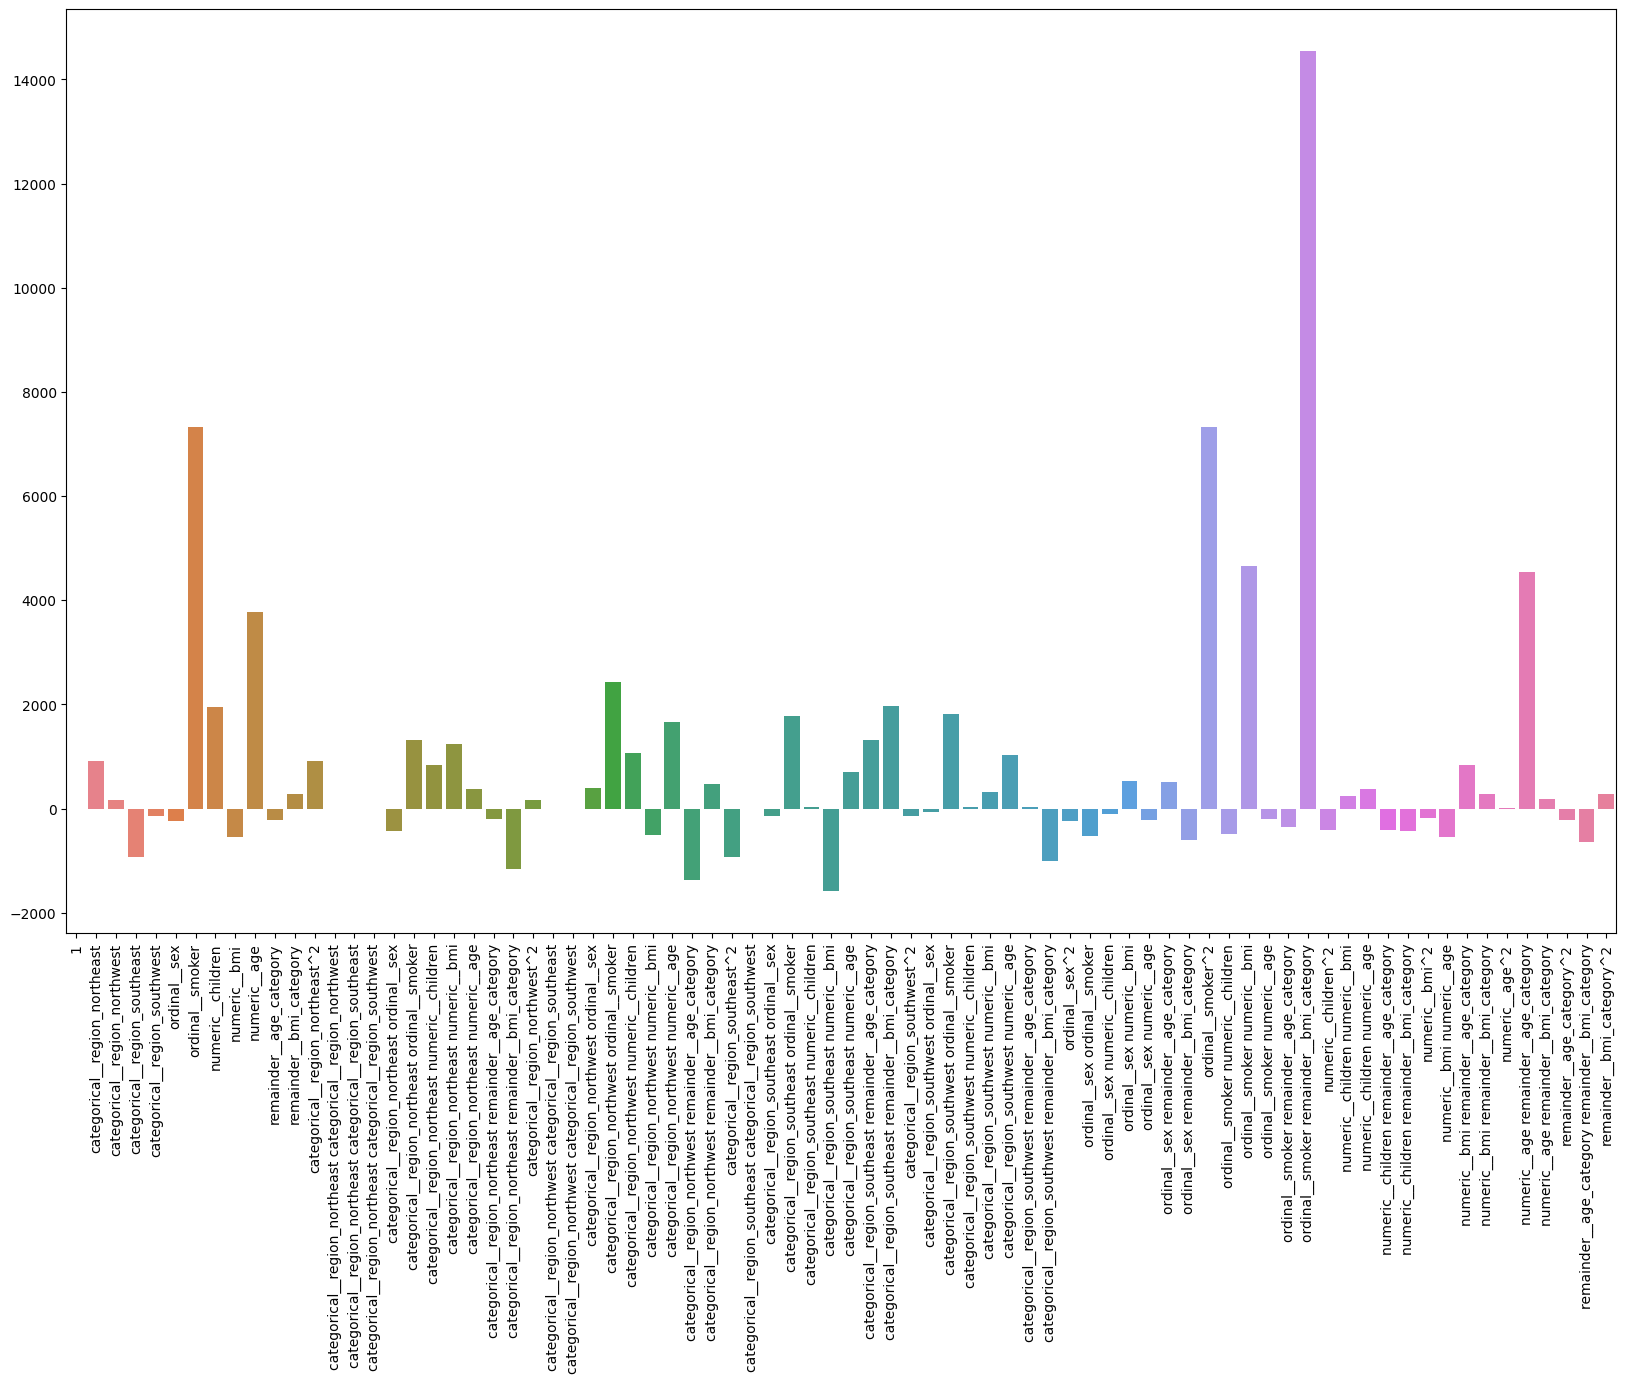

In [24]:
import seaborn as sns

plt.figure(figsize=(20,12))
sns.barplot(data_coeff)
plt.xticks(rotation = 'vertical')
plt.show()

In [25]:
root_mean_squared_error(linear_model.predict(X_test), y_test)

3461.2053709540587

In [26]:
linear_model.score(X_test,y_test)

0.917331694969992

### avec lasso

In [27]:
lasso_model = make_pipeline(preprocessor, PolynomialFeatures(2), Lasso(1))
lasso_model.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=1))])

In [28]:
lasso_model.score(X_test,y_test)

0.9178193959031308

In [29]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3450.9805931893115

Pas de gain significatif. Faison une étude Pour trouver les meilleurs hyper paramètres : 

### Hyperparamètre tuning Lasso

In [30]:
lasso_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("lasso", Lasso())
])


In [31]:
param_grid = {
    "poly__degree": [2, 3], 
    "lasso__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lasso__alpha': np.float64(1.0), 'poly__degree': 2}

In [32]:
grid_search.best_score_

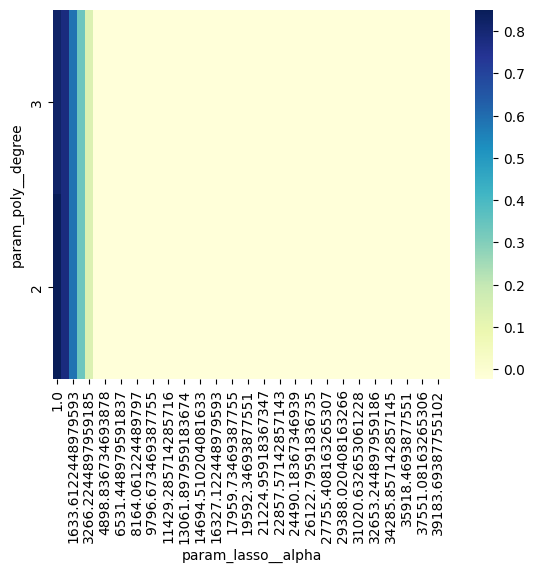

In [33]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__degree"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

on peut abandoner le degre 3 et on va se concentrer sur des valeurs de alpha entre 0 et 100...

In [34]:
param_grid = {
    "lasso__alpha": np.linspace(0, 100, 1001), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

best_param_alpha = grid_search.best_params_

In [35]:
print(best_param_alpha , grid_search.best_score_)

{'lasso__alpha': np.float64(74.4)} 0.8545877750791765


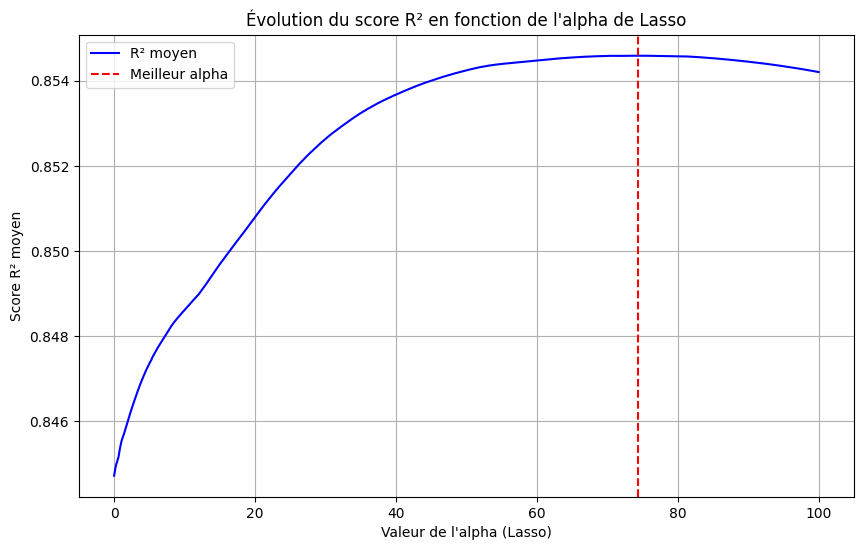

In [36]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

Le meilleur alpha semble être 45. Essayons tout de même entre 0 et 1 :

In [37]:
param_grid = {
    "lasso__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lasso__alpha': np.float64(1.0)}

In [38]:
grid_search.best_score_

np.float64(0.8508663925350015)

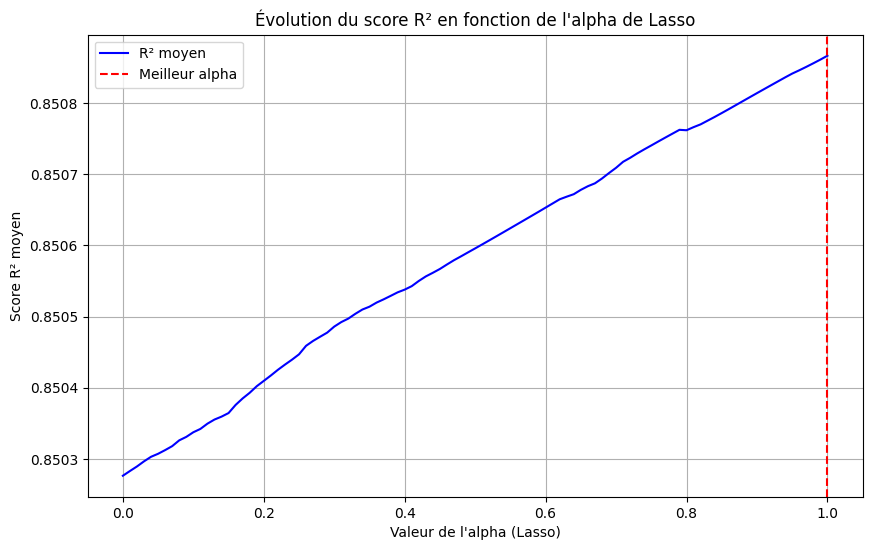

In [39]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

45 et meilleur. Etudions maintenant les carrés du polynôme avec un alpha pour alpha entre 35 et 55 :

In [40]:
param_grid = {
    "poly__interaction_only": [True, False], 
    "lasso__alpha": np.linspace(35, 55, 21), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'lasso__alpha': np.float64(51.0), 'poly__interaction_only': False}

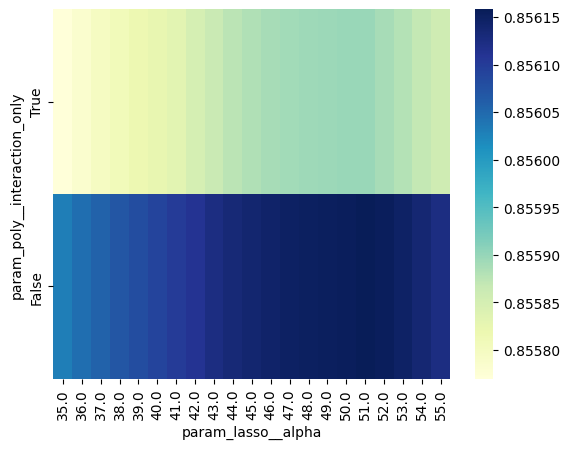

In [41]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["param_poly__interaction_only"],
    columns=["param_lasso__alpha"],
    )

import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, cmap="YlGnBu"
)
ax.invert_yaxis()

On a de meilleurs résultats en conservant les carrés...

In [42]:
best_param_alpha['lasso__alpha']

np.float64(74.4)

In [43]:
lasso_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   Pipeline(steps=[('agetransformer', AgeTransformer(columns='age')),
                   ('bmitransformer', BmiTransformer(columns='bmi')),
                   ('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('categorical',
                                                     OneHotEncoder(), ['region']),
                                                    ('ordinal', OrdinalEncoder(),
                                                     ['sex', 'smoker']),
                                                    ('numeric', RobustScaler(),
                                                     ['children', 'bmi',
                                                      'age'])]))])),
  ('poly', PolynomialFeatures()),
  ('lasso', Lasso())],
 'transform_input': None,
 'verbose': False,
 'preprocessor': Pipeline(steps=[('agetransformer', AgeTransformer(columns='age')

In [44]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'])
lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('poly', PolynomialFeatures()),
                ('lasso', Lasso(alpha=np.float64(74.4)))])

In [45]:
lasso_model.score(X_test,y_test)

0.9252030069663112

L'amélioration est tout de même peu significative...

In [46]:
root_mean_squared_error(lasso_model.predict(X_test), y_test)

3292.3039401384553

### Elastic net

In [47]:
elastic_net_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("elastic", ElasticNet())
])
elastic_net_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('poly', PolynomialFeatures()), ('elastic', ElasticNet())])

In [48]:
ElasticNet().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [49]:
# elastic_net_model.score(X_test,y_test)

In [50]:
# root_mean_squared_error(elastic_net_model.predict(X_test), y_test)

In [51]:
# param_grid = {
#     "elastic__l1_ratio": np.linspace(0, 1, 20), 
#     "elastic__alpha": np.linspace(1, 100, 20)
# }

# grid_search = GridSearchCV(
#     elastic_net_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

In [52]:
# print(grid_search.best_params_, grid_search.best_score_)

In [53]:
# cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
#     "mean_test_score", ascending=False
# )

In [54]:
# column_results = [f"param_{name}" for name in param_grid.keys()]
# column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
# cv_results = cv_results[column_results]

In [55]:
# pivoted_cv_results = cv_results.pivot_table(
#     values="mean_test_score",
#     index=["param_elastic__l1_ratio"],
#     columns=["param_elastic__alpha"],
#     )

In [56]:
# import seaborn as sns

# ax = sns.heatmap(
#     pivoted_cv_results, cmap="YlGnBu"
# )
# ax.invert_yaxis()

In [57]:
# param_grid = {
#     "elastic__l1_ratio": np.linspace(0.9, 1, 20), 
#     "elastic__alpha": np.linspace(50, 150, 100)
# }

# grid_search = GridSearchCV(
#     elastic_net_model,
#     param_grid,
#     cv=5,
#     scoring="r2",
# )
# grid_search.fit(X_train, y_train)

In [58]:
# print(grid_search.best_params_, grid_search.best_score_)

In [59]:
# cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
#     "mean_test_score", ascending=False
# )
# column_results = [f"param_{name}" for name in param_grid.keys()]
# column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
# cv_results = cv_results[column_results]
# pivoted_cv_results = cv_results.pivot_table(
#     values="mean_test_score",
#     index=["param_elastic__l1_ratio"],
#     columns=["param_elastic__alpha"],
#     )

# import seaborn as sns

# ax = sns.heatmap(
#     pivoted_cv_results, cmap="YlGnBu"
# )
# ax.invert_yaxis()


## Analyse des résultats

On va d'abord récuperer nos données transformé.

In [60]:
linear_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [61]:
linear_model[:-1].fit_transform(X_train)

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]], shape=(1136, 78))

In [62]:
linear_model[:-1].get_feature_names_out()

array(['1', 'categorical__region_northeast',
       'categorical__region_northwest', 'categorical__region_southeast',
       'categorical__region_southwest', 'ordinal__sex', 'ordinal__smoker',
       'numeric__children', 'numeric__bmi', 'numeric__age',
       'remainder__age_category', 'remainder__bmi_category',
       'categorical__region_northeast^2',
       'categorical__region_northeast categorical__region_northwest',
       'categorical__region_northeast categorical__region_southeast',
       'categorical__region_northeast categorical__region_southwest',
       'categorical__region_northeast ordinal__sex',
       'categorical__region_northeast ordinal__smoker',
       'categorical__region_northeast numeric__children',
       'categorical__region_northeast numeric__bmi',
       'categorical__region_northeast numeric__age',
       'categorical__region_northeast remainder__age_category',
       'categorical__region_northeast remainder__bmi_category',
       'categorical__region_north

In [63]:
data_transform = pd.DataFrame(data = linear_model[:-1].fit_transform(X_train), columns=linear_model[:-1].get_feature_names_out())

In [64]:
data_transform

,1,categorical__region_northeast,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,ordinal__sex,ordinal__smoker,numeric__children,numeric__bmi,numeric__age,...,numeric__bmi^2,numeric__bmi numeric__age,numeric__bmi remainder__age_category,numeric__bmi remainder__bmi_category,numeric__age^2,numeric__age remainder__age_category,numeric__age remainder__bmi_category,remainder__age_category^2,remainder__age_category remainder__bmi_category,remainder__bmi_category^2
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.5,0.090409,-0.84,...,0.008174,-0.075943,0.000000,0.090409,0.7056,-0.00,-0.84,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.5,0.084461,1.00,...,0.007134,0.084461,0.084461,0.084461,1.0000,1.00,1.00,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.5,-0.327732,-0.80,...,0.107408,0.262186,-0.000000,-0.000000,0.6400,-0.00,-0.00,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.5,-1.559554,-0.80,...,2.432208,1.247643,-0.000000,-0.000000,0.6400,-0.00,-0.00,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.557918,-0.32,...,0.311273,0.178534,-0.000000,-0.000000,0.1024,-0.00,-0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.5,-1.096208,0.24,...,1.201672,-0.263090,-1.096208,-0.000000,0.0576,0.24,0.00,1.0,0.0,0.0
1132,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.5,-0.930260,0.76,...,0.865384,-0.706998,-0.930260,-0.000000,0.5776,0.76,0.00,1.0,0.0,0.0
1133,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.802379,-0.28,...,0.643812,-0.224666,0.000000,0.802379,0.0784,-0.00,-0.28,0.0,0.0,1.0
1134,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.5,-0.367584,0.80,...,0.135118,-0.294067,-0.367584,-0.000000,0.6400,0.80,0.00,1.0,0.0,0.0


In [65]:
X = data_transform
Y = y_train.reset_index()

Je créer une data frame avec nos index pour receuillir les résultats

In [66]:
analyses = pd.DataFrame(Y["index"])
analyses

,index
0,1094
1,94
2,349
3,410
4,981
...,...
1131,674
1132,752
1133,319
1134,934


In [67]:
n,p = X.shape
print(n,p)

1136 78


Ensuite on implémente la régression linéaire avec statsmodels :

In [68]:
import statsmodels.api as sm
reg_multi = sm.OLS(Y.drop("index", axis=1),X) 
reg_multi = reg_multi.fit()


In [69]:
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     126.1
Date:                Fri, 17 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:16:53   Log-Likelihood:                -11154.
No. Observations:                1136   AIC:                         2.242e+04
Df Residuals:                    1080   BIC:                         2.270e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
1                                                            5336.1101    779.666      6.844      0.000    3806.277    6865.943
categorical__region_northeast                                2239.3478    471.794      4.746      0.000    1313.611    3165.085
categorical__region_northwest                                1495.5316    479.100      3.122      0.002     555.459    2435.604
categorical__region_southeast                                 403.7720    408.230      0.989      0.323    -397.241    1204.785
categorical__region_southwest                                1197.4587    454.612      2.634      0.009     305.437    2089.481
ordinal__sex                                                 -232.0692    391.738     -0.592      0.554   -1000.724     536.585
ordinal__smoker                                              7335.2068    516.801     14.193      0.000    6321.158    8349.255
numeric__children                                            1951.6090    659.934      2.957      0.003     656.712    3246.506
numeric__bmi                                                 -549.8352   1068.868     -0.514      0.607   -2647.128    1547.458
numeric__age                                                 3765.5925   1933.029      1.948      0.052     -27.325    7558.510
remainder__age_category                                      -227.2902    612.119     -0.371      0.710   -1428.367     973.787
remainder__bmi_category                                       271.7824    585.483      0.464      0.643    -877.031    1420.596
categorical__region_northeast^2                              2239.3478    471.794      4.746      0.000    1313.611    3165.085
categorical__region_northeast categorical__region_northwest -6.537e-13   2.23e-12     -0.294      0.769   -5.02e-12    3.71e-12
categorical__region_northeast categorical__region_southeast  1.677e-12   1.44e-12      1.162      0.246   -1.16e-12    4.51e-12
categorical__region_northeast categorical__region_southwest  9.192e-13    2.8e-12      0.328      0.743   -4.58e-12    6.42e-12
categorical__region_northeast ordinal__sex                   -433.4286    496.836     -0.872      0.383   -1408.302     541.445
categorical__region_northeast ordinal__smoker                1307.6601    638.562      2.048      0.041      54.698    2560.622
categorical__region_northeast numeric__children               826.7111    452.935      1.825      0.068     -62.021    1715.443
categorical__region_northeast numeric__bmi                   1235.4315    680.760      1.815      0.070    -100.330    2571.193
categorical__region_northeast numeric__age                    375.5346    983.477      0.382      0.703   -1554.208    2305.277
categorical

### Etude d'atypicité

#### Sur les variable explicative

leviers des observations de Bersley : On peut calculer les leviers : $$h_{ii}=X_{i}^T(X^YX)^{-1}X_i$$ Si cette valeur est supérieur au seuil des leviers ($2∗\frac{p}{n}$) on peut considérer l'observation comme atypique.

In [70]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
print(seuil_levier)

0.13732394366197184


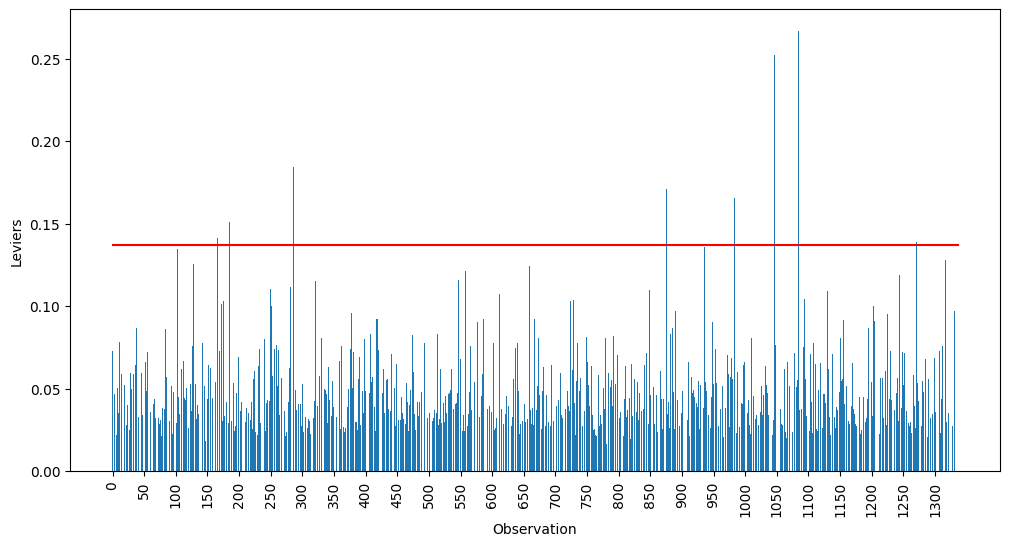

In [71]:
plt.figure(figsize=(12,6))
plt.bar(analyses['index'], analyses['levier'])
plt.xticks(np.arange(0, 1336, step=50), rotation="vertical")
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_levier, seuil_levier], color='r')
plt.show()

In [72]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,index,levier
103,810,0.151831
237,286,0.184665
243,185,0.151244
407,543,0.140553
515,1271,0.138754
576,166,0.141399
596,983,0.165528
689,1084,0.266493
760,1129,0.147782
832,1316,0.237409


Nous n'avons que 15 valeurs atypiques sans considérer la target

#### Sur la variable à expliquer

In [73]:
alpha = 0.05

On calculs les résidus studentisés internes avec scipy et on fixe un alpha à 0.05 pour avoir une confiance de 95%

In [74]:
from scipy.stats import t
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

In [75]:
df.shape

(1337, 7)

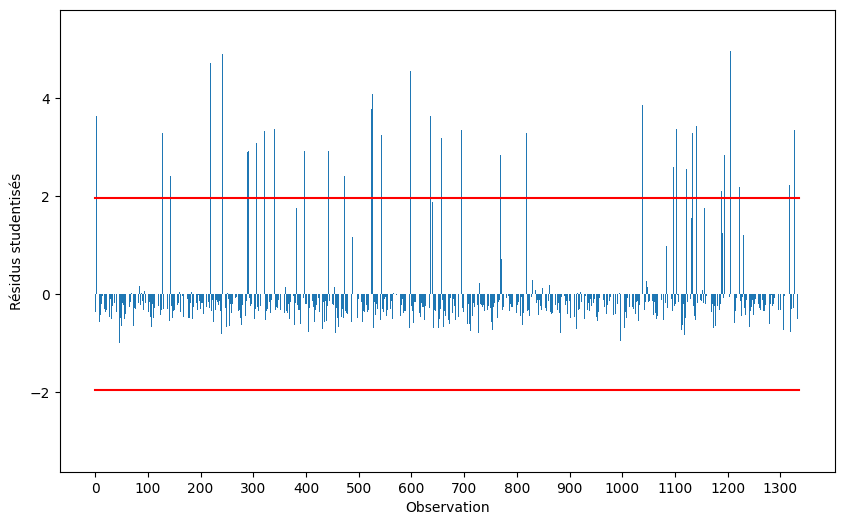

In [76]:
plt.figure(figsize=(10,6))
plt.bar(analyses['index'], analyses['rstudent'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1336], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1336], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [77]:
len(analyses.loc[(analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier),:])

97

In [78]:
df = pd.read_csv("../4072eb5e-e963-4a17-a794-3ea028d0a9c4.csv")

On a 95 valeurs atypiques en tout.

### Etude de l'influence :

On calcul pour charque observation la distance de COOK $D_i$ et on la considère influente si $$D_i > \dfrac{4}{n-p}$$

In [79]:
influence = reg_multi.get_influence().summary_frame()

In [80]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

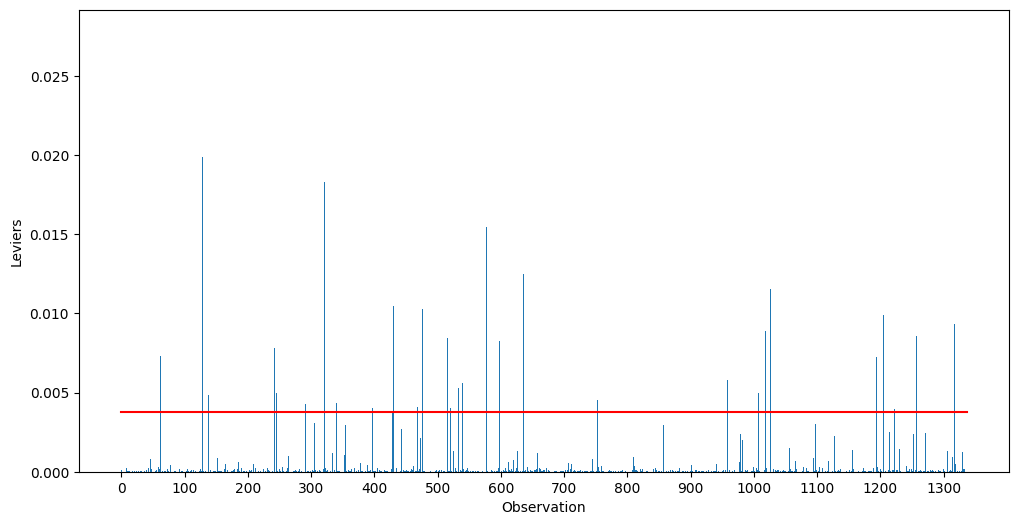

In [81]:
plt.figure(figsize=(12,6))
plt.bar(analyses['index'], analyses['dcooks'])
plt.xticks(np.arange(0, 1336, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1336], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [82]:
len(analyses.loc[analyses['dcooks'] > seuil_dcook, :])

67

On a 60 valeurs influentes. 

In [83]:
len(analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:])

66

Et 59 de ces valeurs sont atypiques.

### Tentative en enlevant les valeurs influentes et atypiques :

In [84]:
obesrvations_to_drop = analyses.loc[(analyses['dcooks'] > seuil_dcook) & ((analyses['rstudent'] > seuil_rstudent) | (analyses['rstudent'] < -seuil_rstudent) | (analyses['levier'] > seuil_levier)),:]

In [85]:
X_train

,age,sex,children,smoker,region,bmi
1094,18,female,4,no,northeast,31.350
94,64,female,2,yes,southwest,31.300
349,19,male,0,no,northwest,27.835
410,19,male,0,no,northwest,17.480
981,31,male,3,yes,southwest,25.900
...,...,...,...,...,...,...
674,45,male,0,no,northwest,21.375
752,58,female,0,no,southeast,22.770
319,32,male,1,no,northeast,37.335
934,59,female,0,no,southwest,27.500


In [86]:
X2_train = X_train
y2_train = y_train
for index in obesrvations_to_drop["index"]:
    X2_train = X2_train.drop(index)
    y2_train = y2_train.drop(index)

In [87]:
lasso_model.fit(X_train,y_train)
print(lasso_model.score(X_test,y_test), lasso_model.score(X_train,y_train))

0.9252030069663112 0.8595096219496478


In [88]:
best_lasso_model = lasso_model.fit(X2_train,y2_train)
print(best_lasso_model.score(X_test,y_test), best_lasso_model.score(X_train,y_train))

0.9308730305611845 0.8504266745925595


In [89]:
root_mean_squared_error(best_lasso_model.predict(X_test), y_test)

3165.0575497653263

On a un meilleur modèle !

In [90]:
param_grid = {
    "lasso__alpha": np.linspace(0, 100, 1001), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

best_param_alpha = grid_search.best_params_

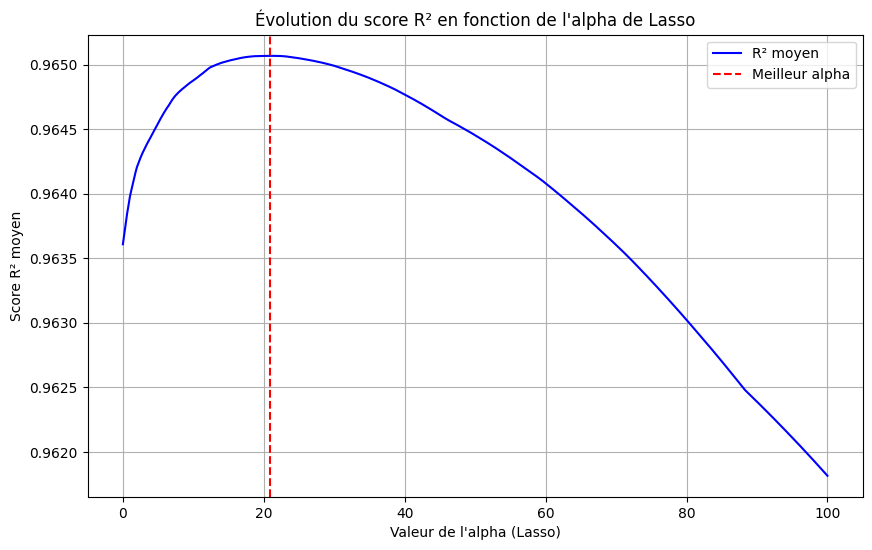

In [91]:
results = grid_search.cv_results_
alphas = results["param_lasso__alpha"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["lasso__alpha"], color="red", linestyle="--", label="Meilleur alpha")
plt.xlabel("Valeur de l'alpha (Lasso)")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction de l'alpha de Lasso")
plt.legend()
plt.grid(True)
plt.show()

In [92]:
best_param_alpha

{'lasso__alpha': np.float64(20.900000000000002)}

In [93]:
best_score = [0,0] # Triiiiiiiiiiiiiiche !

for i in range(0,100):
    lasso_model.set_params(poly__degree=2, lasso__alpha = i)
    best_lasso_model = lasso_model.fit(X2_train,y2_train)
    if best_score[1] < best_lasso_model.score(X_test,y_test) :
        best_score = [i, best_lasso_model.score(X_test,y_test) ]


In [94]:
best_score

[64, 0.9309211783544293]

In [95]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'])
best_lasso_model = lasso_model.fit(X2_train,y2_train)

In [96]:
print(best_lasso_model.score(X_test,y_test), best_lasso_model.score(X_train,y_train))

0.9296810614857773 0.8534604751880089


In [97]:
import pickle

with open('best_lasso_model.pkl', 'wb') as f:
    pickle.dump(best_lasso_model, f)

### Meilleurs seuil d'age

In [98]:
best_lasso_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   Pipeline(steps=[('agetransformer', AgeTransformer(columns='age')),
                   ('bmitransformer', BmiTransformer(columns='bmi')),
                   ('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('categorical',
                                                     OneHotEncoder(), ['region']),
                                                    ('ordinal', OrdinalEncoder(),
                                                     ['sex', 'smoker']),
                                                    ('numeric', RobustScaler(),
                                                     ['children', 'bmi',
                                                      'age'])]))])),
  ('poly', PolynomialFeatures()),
  ('lasso', Lasso(alpha=np.float64(20.900000000000002)))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': Pipeline(steps=[('agetransfo

In [99]:
param_grid = {
    "preprocessor__agetransformer__k": np.linspace(10, 90, 101), 
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

best_param_k = grid_search.best_params_

In [100]:
best_param_k

{'preprocessor__agetransformer__k': np.float64(59.6)}

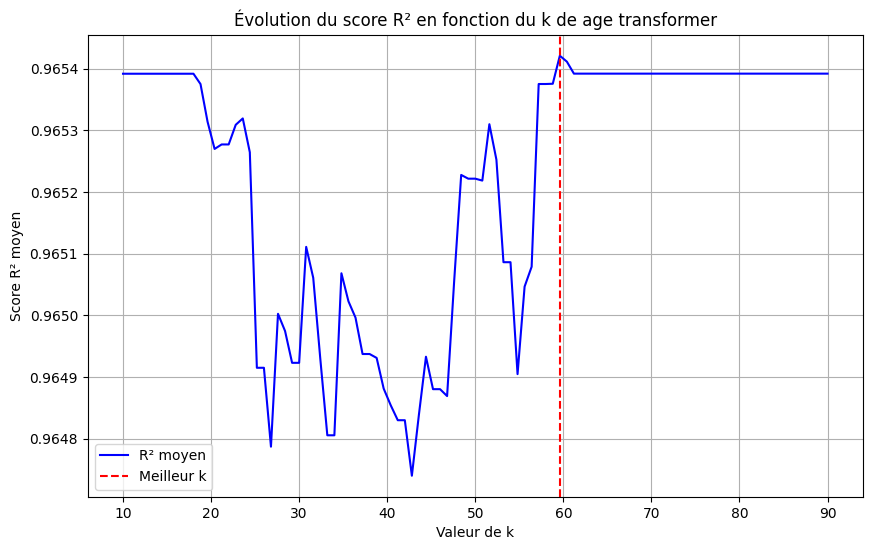

In [101]:
results = grid_search.cv_results_
alphas = results["param_preprocessor__agetransformer__k"].data
mean_scores = results["mean_test_score"]  


plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_scores, label="R² moyen", color="blue")

# Ajouter des annotations
plt.axvline(grid_search.best_params_["preprocessor__agetransformer__k"], color="red", linestyle="--", label="Meilleur k")
plt.xlabel("Valeur de k")
plt.ylabel("Score R² moyen")
plt.title("Évolution du score R² en fonction du k de age transformer")
plt.legend()
plt.grid(True)
plt.show()

In [102]:
lasso_model.set_params(poly__degree=2, lasso__alpha = best_param_alpha['lasso__alpha'], preprocessor__agetransformer__k = best_param_k["preprocessor__agetransformer__k"])
best_lasso_model = lasso_model.fit(X2_train,y2_train)

In [103]:
best_lasso_model.score(X_test,y_test)

0.9296263157287559

### Etude de la colinéarité

In [104]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = reg_multi.model.exog
v = [variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

In [105]:
v = [item for item in v if item >10]
v

[np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(inf),
 np.float64(13.727217745887891),
 np.float64(inf),
 np.float64(10.10338325652579),
 np.float64(13.10161508841526),
 np.float64(29.666093043498112),
 np.float64(34.879865411223626),
 np.float64(11.742869049382

Pas de colinéarité...

### Ridge

In [106]:
ridge_model = Pipeline([
    ("preprocessor", preprocessor),
    ("poly", PolynomialFeatures()),
    ("ridge", Ridge())
])

In [107]:
param_grid = {
    "ridge__alpha": np.linspace(1, 40000, 50), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('agetransformer',
                                                         AgeTransformer(columns='age',
                                                                        k=np.float64(59.6))),
                                                        ('bmitransformer',
                                                         BmiTransformer(columns='bmi')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('categorical',
                                                                                          OneHotEncoder(),
                                                                                          ['region']),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(),
                                                                                          ['sex',
                                                                                           's...
       1.95923469e+04, 2.04086531e+04, 2.12249592e+04, 2.20412653e+04,
       2.28575714e+04, 2.36738776e+04, 2.44901837e+04, 2.53064898e+04,
       2.61227959e+04, 2.69391020e+04, 2.77554082e+04, 2.85717143e+04,
       2.93880204e+04, 3.02043265e+04, 3.10206327e+04, 3.18369388e+04,
       3.26532449e+04, 3.34695510e+04, 3.42858571e+04, 3.51021633e+04,
       3.59184694e+04, 3.67347755e+04, 3.75510816e+04, 3.83673878e+04,
       3.91836939e+04, 4.00000000e+04])},
             scoring='r2')

In [108]:
grid_search.best_params_

{'ridge__alpha': np.float64(1.0)}

In [109]:
param_grid = {
    "ridge__alpha": np.linspace(0, 1, 101), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('agetransformer',
                                                         AgeTransformer(columns='age',
                                                                        k=np.float64(59.6))),
                                                        ('bmitransformer',
                                                         BmiTransformer(columns='bmi')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('categorical',
                                                                                          OneHotEncoder(),
                                                                                          ['region']),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(),
                                                                                          ['sex',
                                                                                           's...
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])},
             scoring='r2')

In [110]:
grid_search.best_params_

{'ridge__alpha': np.float64(0.36)}

In [111]:
param_grid = {
    "ridge__alpha": np.linspace(0, 0.001, 101), 
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=2,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)
grid_search.best_params_

{'ridge__alpha': np.float64(0.001)}

In [112]:
best_param_r_alpha = grid_search.best_params_

In [113]:
grid_search.best_score_

np.float64(0.9644781711300185)

In [114]:
ridge_model.set_params(ridge__alpha = best_param_r_alpha['ridge__alpha'])
best_ridge_model = ridge_model.fit(X2_train,y2_train)

In [115]:
best_ridge_model.score(X_test,y_test)

0.9265587560115814

## Lasso with target regression

In [116]:
lasso_model.fit(X2_train, np.log(y2_train))

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age',
                                                 k=np.float64(59.6))),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('poly', PolynomialFeatures()),
                ('lasso', Lasso(alpha=np.float64(20.900000000000002)))])

In [117]:
lasso_model_targettransformed = TransformedTargetRegressor(regressor=lasso_model,func=np.log,inverse_func=np.exp)

In [118]:
lasso_model_targettransformed.fit(X2_train,y2_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('agetransformer',
                                                                       AgeTransformer(columns='age',
                                                                                      k=np.float64(59.6))),
                                                                      ('bmitransformer',
                                                                       BmiTransformer(columns='bmi')),
                                                                      ('columntransformer',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('categorical',
                                                                                                        OneHotEncoder(),
                                                                                                        ['region']),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder(),
                                                                                                        ['sex',
                                                                                                         'smoker']),
                                                                                                       ('numeric',
                                                                                                        RobustScaler(),
                                                                                                        ['children',
                                                                                                         'bmi',
                                                                                                         'age'])]))])),
                                                     ('poly',
                                                      PolynomialFeatures()),
                                                     ('lasso',
                                                      Lasso(alpha=np.float64(20.900000000000002)))]))

In [119]:
lasso_model_targettransformed.score(X_test,y_test)

-0.12627408846534904

In [120]:
lasso_model_targettransformed.score(X_test,y_test)

-0.12627408846534904

In [121]:
## Huber regressor

In [122]:
from sklearn.linear_model import HuberRegressor
huber_model = make_pipeline(preprocessor, PolynomialFeatures(), HuberRegressor())
huber_model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age',
                                                 k=np.float64(59.6))),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('huberregressor', HuberRegressor())])

In [123]:
huber_model.score(X_test, y_test)

0.9280887939659777

In [124]:
param_grid = {
    "huberregressor__epsilon": np.linspace(0, 2, 101), 
}

grid_search = GridSearchCV(
    huber_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('agetransformer',
                                                         AgeTransformer(columns='age',
                                                                        k=np.float64(59.6))),
                                                        ('bmitransformer',
                                                         BmiTransformer(columns='bmi')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('categorical',
                                                                                          OneHotEncoder(),
                                                                                          ['region']),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(),
                                                                                          ['sex',
                                                                                           'smoke...
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])},
             scoring='r2')

In [125]:
h_best = grid_search.best_params_["huberregressor__epsilon"]

In [126]:
huber_model.set_params(huberregressor__epsilon = h_best)
best_huber_model = huber_model.fit(X2_train,y2_train)

In [127]:
best_huber_model.score(X_test, y_test)

0.9280520437785986

## Random forest

In [128]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_model.fit(X2_train,y2_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age',
                                                 k=np.float64(59.6))),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('model', RandomForestRegressor(random_state=42))])

In [129]:
rf_model.score(X_test,y_test)

0.9195105373152094

In [130]:
rf_model.get_params()

{'memory': None,
 'steps': [('preprocessor', Pipeline(steps=[('agetransformer',
                    AgeTransformer(columns='age', k=np.float64(59.6))),
                   ('bmitransformer', BmiTransformer(columns='bmi')),
                   ('columntransformer',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('categorical',
                                                     OneHotEncoder(), ['region']),
                                                    ('ordinal', OrdinalEncoder(),
                                                     ['sex', 'smoker']),
                                                    ('numeric', RobustScaler(),
                                                     ['children', 'bmi',
                                                      'age'])]))])),
  ('model', RandomForestRegressor(random_state=42))],
 'transform_input': None,
 'verbose': False,
 'preprocessor': Pipeline(steps=[('agetransform

In [131]:
param_grid = {
    "model__n_estimators": np.linspace(1, 200, 101).astype(int), 
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('agetransformer',
                                                         AgeTransformer(columns='age',
                                                                        k=np.float64(59.6))),
                                                        ('bmitransformer',
                                                         BmiTransformer(columns='bmi')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('categorical',
                                                                                          OneHotEncoder(),
                                                                                          ['region']),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(),
                                                                                          ['sex',
                                                                                           's...
             param_grid={'model__n_estimators': array([  1,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200])},
             scoring='r2')

In [132]:
rf_best = grid_search.best_params_["model__n_estimators"]
rf_best

np.int64(200)

In [133]:
rf_model.set_params(model__n_estimators = rf_best)
rf_model = rf_model.fit(X2_train,y2_train)
rf_model.score(X_test,y_test)

0.9190258957742408

In [134]:
rf_model.set_params(model__n_estimators = 100)
rf_model = rf_model.fit(X2_train,y2_train)
rf_model.score(X_test,y_test)

0.9195105373152094

In [135]:
rf_model.score(X_test,y_test)

0.9195105373152094

In [136]:
param_grid = {
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.8],
    "model__bootstrap": [True, False]
}

grid_search = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring="r2",
)
grid_search.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('agetransformer',
                                                         AgeTransformer(columns='age',
                                                                        k=np.float64(59.6))),
                                                        ('bmitransformer',
                                                         BmiTransformer(columns='bmi')),
                                                        ('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('categorical',
                                                                                          OneHotEncoder(),
                                                                                          ['region']),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder(),
                                                                                          ['sex',
                                                                                           'smoker']),
                                                                                         ('numeric',
                                                                                          RobustScaler(),
                                                                                          ['children',
                                                                                           'bmi',
                                                                                           'age'])]))])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': [None, 10, 20],
                         'model__max_features': ['sqrt', 'log2', 0.8],
                         'model__min_samples_leaf': [1, 5, 10],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='r2')

In [137]:
rf_best = grid_search.best_params_
rf_best

{'model__bootstrap': True,
 'model__max_depth': None,
 'model__max_features': 0.8,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 2}

In [138]:
rf_model.set_params(**rf_best)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age',
                                                 k=np.float64(59.6))),
                                 ('bmitransformer',
                                  BmiTransformer(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('model',
                 RandomForestRegressor(max_features=0.8, min_samples_leaf=5,
                                       random_state=42))])

In [139]:
rf_model.score(X_test,y_test)

0.9195105373152094

In [140]:
rf_model_targettransformed = TransformedTargetRegressor(regressor=rf_model,func=np.log,inverse_func=np.exp)

In [141]:
rf_model_targettransformed.fit(X2_train,y2_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('agetransformer',
                                                                       AgeTransformer(columns='age',
                                                                                      k=np.float64(59.6))),
                                                                      ('bmitransformer',
                                                                       BmiTransformer(columns='bmi')),
                                                                      ('columntransformer',
                                                                       ColumnTransformer(remainder='passthrough',
                                                                                         transformers=[('categorical',
                                                                                                        OneHotEncoder(),
                                                                                                        ['region']),
                                                                                                       ('ordinal',
                                                                                                        OrdinalEncoder(),
                                                                                                        ['sex',
                                                                                                         'smoker']),
                                                                                                       ('numeric',
                                                                                                        RobustScaler(),
                                                                                                        ['children',
                                                                                                         'bmi',
                                                                                                         'age'])]))])),
                                                     ('model',
                                                      RandomForestRegressor(max_features=0.8,
                                                                            min_samples_leaf=5,
                                                                            random_state=42))]))

In [142]:
rf_model_targettransformed.score(X_test,y_test)

0.9251086487901292

In [143]:
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model_targettransformed, f)

In [144]:
class BmiTransformer2(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, k=29.999):
        self.columns = columns 
        self.k = k
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X0):
        X = pd.DataFrame(X0)
        if self.columns == "bmi":
            bins = [0, 18.5, 24.9, 29.9, 40, 100]
            labels = ['Sous-poids', 'Poids normal', 'Surpoids', 'Obésité', 'Obésité sévère']
            X["bmi_category"] = pd.cut(X['bmi'], bins=bins, labels=labels, right=False)
        else:
            raise ValueError("Vous devez spécifier les colonnes à transformer.")
        return X

In [145]:
preprocessor = make_pipeline(AgeTransformer("age"), BmiTransformer2("bmi"), ColumnTransformer(
    [("ordinal_bmi", OrdinalEncoder(), ["bmi_category"]),
     ("categorical", OneHotEncoder(), categorical_column),
    ("ordinal", OrdinalEncoder(), ordinal_column),
    ("numeric", RobustScaler(), numerical_column),
    ],
    remainder="passthrough",
))

rf_model = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=42))
rf_model.fit(X2_train,y2_train)
rf_model.score(X_test,y_test)

0.9168551048128512

## Gradient boosting

In [146]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor())
])
gb_model.fit(X2_train,y2_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('agetransformer',
                                  AgeTransformer(columns='age')),
                                 ('bmitransformer2',
                                  BmiTransformer2(columns='bmi')),
                                 ('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('ordinal_bmi',
                                                                   OrdinalEncoder(),
                                                                   ['bmi_category']),
                                                                  ('categorical',
                                                                   OneHotEncoder(),
                                                                   ['region']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['sex',
                                                                    'smoker']),
                                                                  ('numeric',
                                                                   RobustScaler(),
                                                                   ['children',
                                                                    'bmi',
                                                                    'age'])]))])),
                ('model', GradientBoostingRegressor())])

In [147]:
gb_model.score(X_test,y_test)

0.9252110036007279

## Learning curve

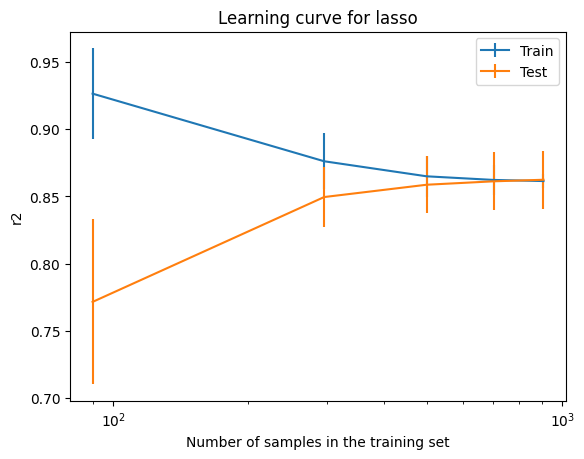

In [148]:
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)

display = LearningCurveDisplay.from_estimator(
    best_lasso_model,
    X_train,
    y_train,
    train_sizes=train_sizes,
    cv=cv,
    score_type="both",  # both train and test errors
    scoring="r2",
    score_name="r2",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set(xscale="log", title="Learning curve for lasso")